In [1]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import wandb
from fastbook import *

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
# login to wandb so we can track runs
wandb.login()

wandb: Currently logged in as: hamish-cam. Use `wandb login --relogin` to force relogin


True

# Load and Split Datasets 

In [3]:
# load in the complete preprocessed dataset
df = pd.read_csv('depth_dataset.csv', index_col='system:index')

# get the feature names from the column headings 
feature_names = [i for i in df.columns]
feature_names.remove('depth')
feature_names.remove('partner')
feature_names.remove('location')

# use only historical data for training and testing (MVP)
df_oldData = df.loc[df['date'] < 2018]
splits_test = TrainTestSplitter(test_size=0.3, random_state=10, shuffle=True)(df_oldData)
test_df = df_oldData.iloc[splits_test[1],:]

# use everything else as the test set
df = df_oldData.iloc[splits_test[0],:]
#df = df.loc[df['location'] != 'Sedge Fen']

# some models need explicit datasets
x_train = df.drop(['depth','partner','location'], axis=1)
y_train = df['depth']
x_test = test_df.drop(['depth','partner','location'], axis=1)
y_test = test_df['depth']

# Select subset of features for experiment 

In [4]:
# print all features that we must select a subset of
feature_names

['date',
 'CROPTYPE',
 'd2_River',
 'AV_STK_100',
 'REdge1',
 'REdge2',
 'REdge3',
 'NDVI',
 'REdge4',
 'Landcover',
 'Elevation',
 'PALSAR_HH',
 'PALSAR_Index1',
 'Sen1_Index3',
 'Sen1_Index2',
 'PALSAR_Index3',
 'Sen1_Index1',
 'PALSAR_Index2',
 'Sen1_VH',
 'Soilscapes',
 'MRRTF',
 'Peaty Soils',
 'PALSAR_HV',
 'Blue',
 'AV_STK_30',
 'TWI',
 'NDWI',
 'Sen1_VV',
 'Red',
 'Soiltype',
 'd2_Watercourse',
 'AV_STK_150',
 'MRVBF',
 'NDMI',
 'NIR',
 'Landcover_conf',
 'Green',
 'SWIR1',
 'SWIR2']

In [5]:
# select the features we want to include #['AV_STK_100', 'AV_STK_150']
selected_features = ['date',
 'CROPTYPE',
 'd2_River',
 'AV_STK_100',
 'REdge1',
 'REdge2',
 'REdge3',
 'NDVI',
 'REdge4',
 'Landcover',
 'Elevation',
 'PALSAR_HH',
 'PALSAR_Index1',
 'Sen1_Index3',
 'Sen1_Index2',
 'PALSAR_Index3',
 'Sen1_Index1',
 'PALSAR_Index2',
 'Sen1_VH',
 'Soilscapes',
 'MRRTF',
 'Peaty Soils',
 'PALSAR_HV',
 'Blue',
 'AV_STK_30',
 'TWI',
 'NDWI',
 'Sen1_VV',
 'Red',
 'Soiltype',
 'd2_Watercourse',
 'AV_STK_150',
 'MRVBF',
 'NDMI',
 'NIR',
 'Landcover_conf',
 'Green',
 'SWIR1',
 'SWIR2']

# Setup wandb Tracking

In [6]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Depth Mapping",
    name="Historical Data only - with LandIS, depth=3",
    
    # track hyperparameters
    config={
        "features included": selected_features
    }
)

# Train a RF model

In [7]:
# instantiate the random forest regressor object
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 1, oob_score=True, max_depth=3)
 
# fit the random forest to the selected training predictor and target data
rf_model.fit(x_train[selected_features], y_train) 

RandomForestRegressor(max_depth=3, oob_score=True, random_state=1)

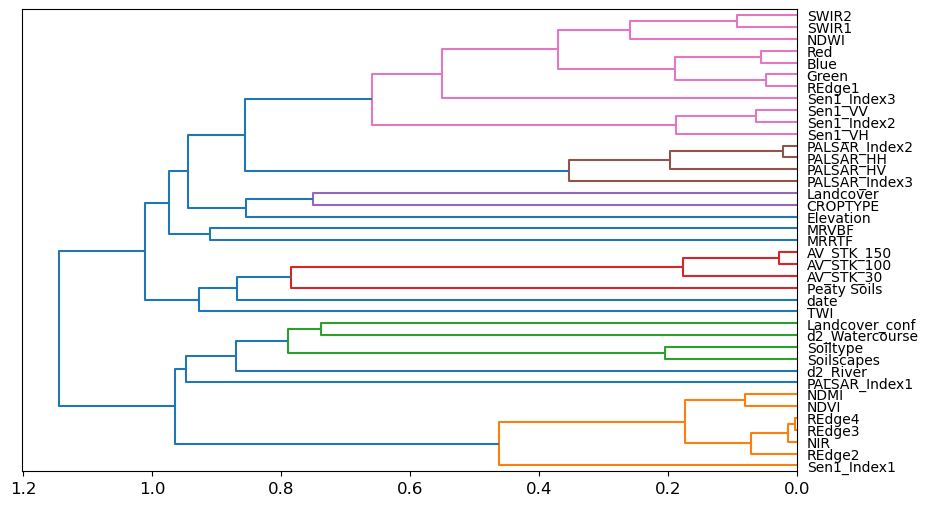

In [8]:
# function to create a dendrogram using rank correlation
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    return fig

# create a diagram showing how correlated the selected predictors are
rank_corr = cluster_columns(x_train[selected_features], font_size=10);

# log this in wandb
wandb.log({"Rank Correlation": wandb.Image(rank_corr)})

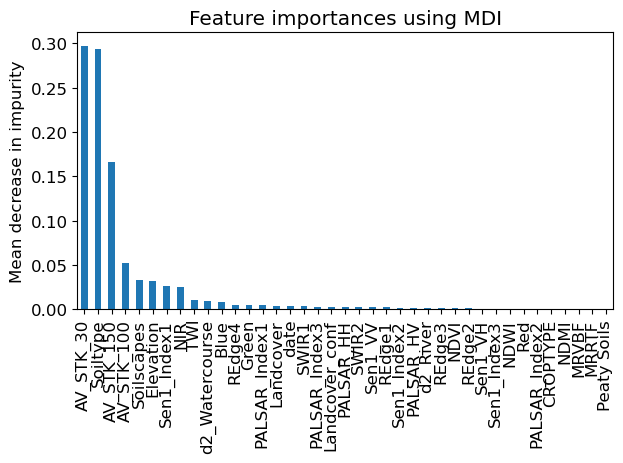

In [9]:
# study the feature importances output by the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=selected_features)
forest_importances = forest_importances.sort_values().iloc[::-1]

# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# save the same plot in wandb for later reference 
wandb.log({"Feature Importance": wandb.Image(fig)})

In [10]:
# make some predictions using our trained model
y_pred_train = rf_model.predict(x_train[selected_features])
y_pred_test = rf_model.predict(x_test[selected_features])

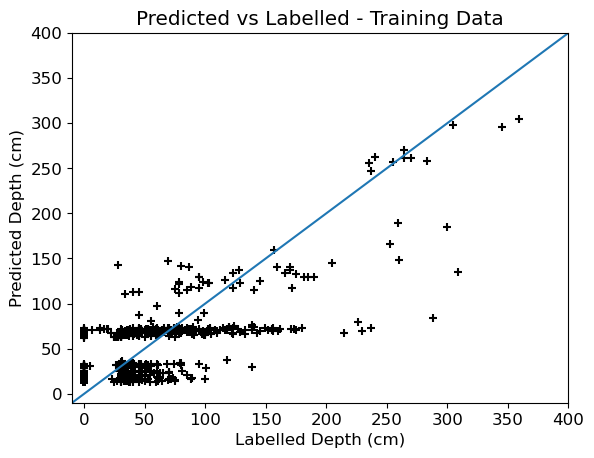

In [11]:
# plot a scatter plot of the predictions using the training set (qualitative performance metric)
plt.scatter(y_train, y_pred_train, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

# save the same plot in wandb for later reference 
wandb.log({"Training Predictions": wandb.Image(ax)})

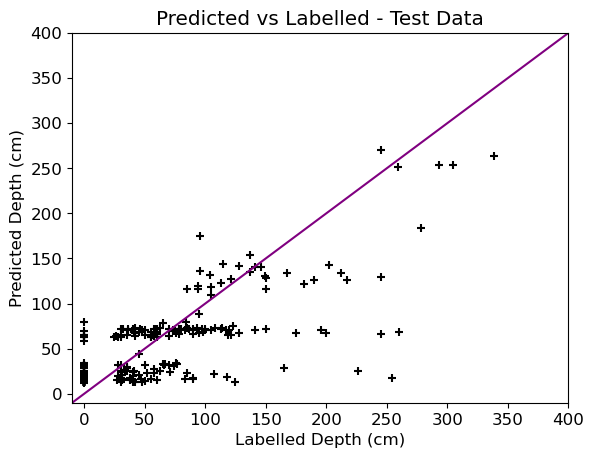

In [12]:
# plot for the test set also 
plt.scatter(y_test, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

# save the same plot in wandb for later reference 
wandb.log({"Test Predictions": wandb.Image(ax)})

In [13]:
# Now calculate some metrics to track quantitive performance 
# OOB error used to see performance on unseen data - limits overfitting
print("Out of bag error:", rf_model.oob_score_, "\n")

# R2 score and RMSE for training set
R_squared_train = r2_score(y_train, y_pred_train)
RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("R Squared (training):", R_squared_train)
print("RMSE (training):", RMSE_train, "\n")

# R2 score and RMSE for test set (only contains new data!)
R_squared_test = r2_score(y_test, y_pred_test)
RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("R Squared (test):", R_squared_test)
print("RMSE (test):", RMSE_test)

# save metrics to wandb for this experiment also
wandb.log({"OOB error": rf_model.oob_score_, 
           "R2 (training)": R_squared_train,
           "RMSE (training)": RMSE_train,
           "R2 (test)": R_squared_test,
           "RMSE (test)": RMSE_test})

Out of bag error: 0.4885113652633368 

R Squared (training): 0.6198343657170244
RMSE (training): 37.88474378940986 

R Squared (test): 0.588985166482608
RMSE (test): 42.37679004157455


In [14]:
# Finish the wandb run, necessary in notebooks
wandb.finish()

OOB error,▁
R2 (test),▁
R2 (training),▁
RMSE (test),▁
RMSE (training),▁
OOB error,0.48851
R2 (test),0.58899
R2 (training),0.61983
RMSE (test),42.37679
RMSE (training),37.88474
